In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")


Mounted at /content/gdrive


In [ ]:
# references: https://www.kaggle.com/code/hamditarek/fake-news-detection-on-twitter-eda
#https://www.kaggle.com/code/mitramir5/nlp-visualization-eda-glove
# https://www.kaggle.com/code/tuckerarrants/disaster-tweets-eda-glove-rnns-bert/notebook
#paper: https://arxiv.org/abs/2110.08010

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 150)
import os
import gc
gc.enable()
import time
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack
from scipy import stats
%matplotlib inline
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import warnings
warnings.filterwarnings('ignore')
import urllib        #for url stuff

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast


from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

import seaborn as sns #for making plots
import matplotlib.pyplot as plt # for plotting
import os  # for os commands

import gensim
from gensim import corpora, models, similarities
import logging
import tempfile
from nltk.corpus import stopwords
from string import punctuation
from collections import OrderedDict

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE


from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

In [ ]:
## Common Variables for Notebook 
ROOT = '/content/gdrive/MyDrive/DATA255_Group_Work/data/'

## load the data 
df_train = pd.read_csv(ROOT+'train.csv')
df_test = pd.read_csv(ROOT+'test.csv')
df_sub = pd.read_csv(ROOT+'sample_submission.csv')

In [ ]:
#Looking data format and types
print(df_train.info())
print(df_test.info())
print(df_sub.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0  

In [ ]:
print('shape of training set: ', df_train.shape)
print('shape of testing set: ', df_test.shape)

shape of training set:  (7613, 5)
shape of testing set:  (3263, 4)


As we can see the traning data is about 2 times bigger than the testing data (which can be very useful because we have more data to train our model) and has 5 columns. The one column that the testing lacks is the target that we have to predict.

In [ ]:
#Some Statistics
df_train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [ ]:
#Take a look at the data
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


**id:** the identification number of each tweet that separates it from other tweets.

**keyword:** The one specific word that has been found in many tweets

**location:** where was the person who tweeted?

**text:** The most important field that we rely our prediction on

**target:** Is the tweet disastrous or not?

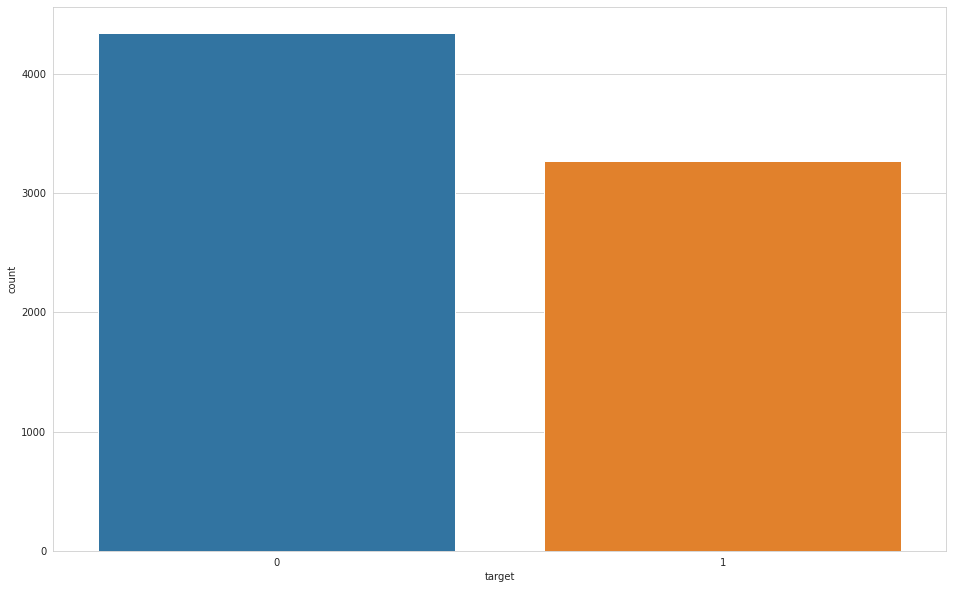

In [ ]:
#exploring the data
#Checking target distribution
#check for class imbalance
target = df_train['target']
sns.set_style('whitegrid')
sns.countplot(target)

In [ ]:
#checking text content
df_train["text"].head()

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object

In [ ]:
#To check the text content we can use a list
df_train["text"].tolist()[:5]

['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
 'Forest fire near La Ronge Sask. Canada',
 "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
 '13,000 people receive #wildfires evacuation orders in California ',
 'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school ']

In [ ]:
t = df_train["text"].to_list()
for i in range(5):
    print('Tweet Number '+str(i+1)+': '+t[i])

Tweet Number 1: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Tweet Number 2: Forest fire near La Ronge Sask. Canada
Tweet Number 3: All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
Tweet Number 4: 13,000 people receive #wildfires evacuation orders in California 
Tweet Number 5: Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 


Location:

Can this field help? lets see what are the most common locations and how many there are. This field contains users inputs and were not automatically generated. take a look at it. it's very dirty and even same places don't have the same name. but first it's good to take a look at the common places people tweet from.

In [ ]:
#tweets locations
l = df_train["location"].to_list()
print('There is '+ str(len(set(l)))+" different loction")

There is 3342 different loction


In [ ]:
#count locations
#top 20 posting locations
df_train['location'].value_counts().head(n=20)

USA                104
New York            71
United States       50
London              45
Canada              29
Nigeria             28
UK                  27
Los Angeles, CA     26
India               24
Mumbai              22
Washington, DC      21
Kenya               20
Worldwide           19
Australia           18
Chicago, IL         18
California          17
Everywhere          15
New York, NY        15
California, USA     15
Florida             14
Name: location, dtype: int64

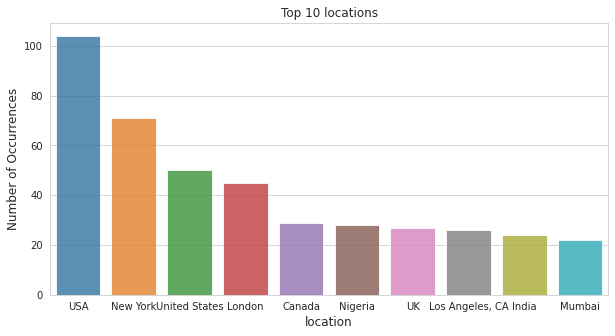

In [ ]:
# Plotting a bar graph of the number of tweets in each location, for the first ten locations listed
# in the column 'location'
location_count  = df_train['location'].value_counts()
location_count = location_count[:10,]
plt.figure(figsize=(10,5))
sns.barplot(location_count.index, location_count.values, alpha=0.8)
plt.title('Top 10 locations')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('location', fontsize=12)
plt.show()


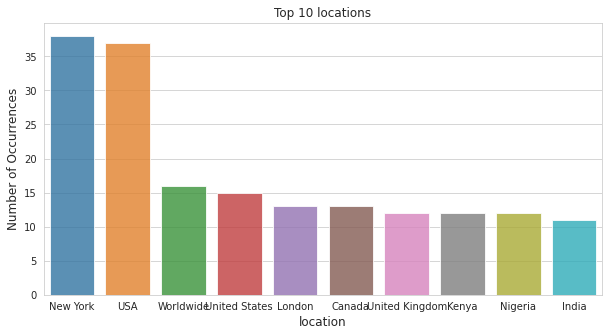

In [ ]:
#test data
# Plotting a bar graph of the number of tweets in each location, for the first ten locations listed
# in the column 'location'
location_count  = df_test['location'].value_counts()
location_count = location_count[:10,]
plt.figure(figsize=(10,5))
sns.barplot(location_count.index, location_count.values, alpha=0.8)
plt.title('Top 10 locations')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('location', fontsize=12)
plt.show()

Keyword:

This is one word or phrase from the text field. Let's see what keywords were used most often and which usually came with disastrous tweets.

In [ ]:
# for word cloud
from PIL import Image
from wordcloud import WordCloud 


In [ ]:
#checking keywords
#counting keywords
#top 20 keywords
df_train['keyword'].value_counts().head(n=20)

fatalities     45
deluge         42
armageddon     42
sinking        41
damage         41
harm           41
body%20bags    41
outbreak       40
evacuate       40
fear           40
collided       40
siren          40
twister        40
windstorm      40
sinkhole       39
sunk           39
hellfire       39
weapon         39
weapons        39
famine         39
Name: keyword, dtype: int64

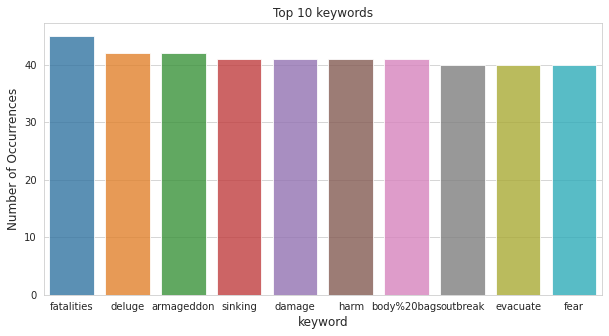

In [ ]:
keyword_count  = df_train['keyword'].value_counts()
keyword_count = keyword_count[:10,]
plt.figure(figsize=(10,5))
sns.barplot(keyword_count.index, keyword_count.values, alpha=0.8)
plt.title('Top 10 keywords')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('keyword', fontsize=12)
plt.show()


In [ ]:
#test data
df_test['keyword'].value_counts().head(n=20)

deluged               23
demolished            22
rubble                22
first%20responders    21
seismic               21
obliteration          21
sirens                21
annihilation          21
snowstorm             21
avalanche             20
dead                  20
mayhem                20
bioterrorism          20
catastrophic          20
survivors             20
devastated            19
crushed               19
hostage               19
wild%20fires          19
suicide%20bomber      19
Name: keyword, dtype: int64

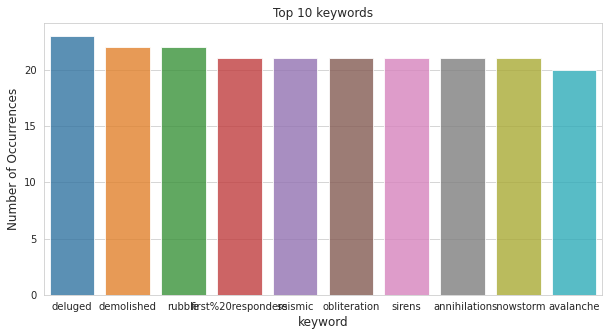

In [ ]:
keyword_count  = df_test['keyword'].value_counts()
keyword_count = keyword_count[:10,]
plt.figure(figsize=(10,5))
sns.barplot(keyword_count.index, keyword_count.values, alpha=0.8)
plt.title('Top 10 keywords')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('keyword', fontsize=12)
plt.show()

In [ ]:
keyword_train  = list(set(df_train['keyword']))
keyword_test  = list(set(df_test['keyword']))

print(len(keyword_train))
print(len(keyword_test))

222
222


There is 222 unique values in both train and test sets

In [ ]:
#intersection
def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 

len(intersection(keyword_train, keyword_test))

222

The intersection between the two datasets give us the same number of unique keywords, so the keywords used in both datasets with different occurrence

In [ ]:
counting_tweets = df_train.groupby(['keyword', 'target']).count().reset_index()

counting_tweets = pd.pivot_table(counting_tweets, 
               values = 'text', # count of tweets in here
               index = 'keyword',# index is keyword
               columns = 'target') # columns will be 0 and 1



# let's have the keywords most used in disastrous tweets on top
# also some keywords don't appear in both categories 
# so we fill the null values with 0

counting_tweets = counting_tweets.fillna(0).sort_values([0, 1], ascending = [True, False])
counting_tweets

target,0,1
keyword,,
derailment,0.0,39.0
wreckage,0.0,39.0
debris,0.0,37.0
outbreak,1.0,39.0
oil%20spill,1.0,37.0
...,...,...
wrecked,36.0,3.0
ruin,36.0,1.0
armageddon,37.0,5.0


In [ ]:
counting_tweets = counting_tweets.apply(lambda x: x*100/sum(x), axis=1)

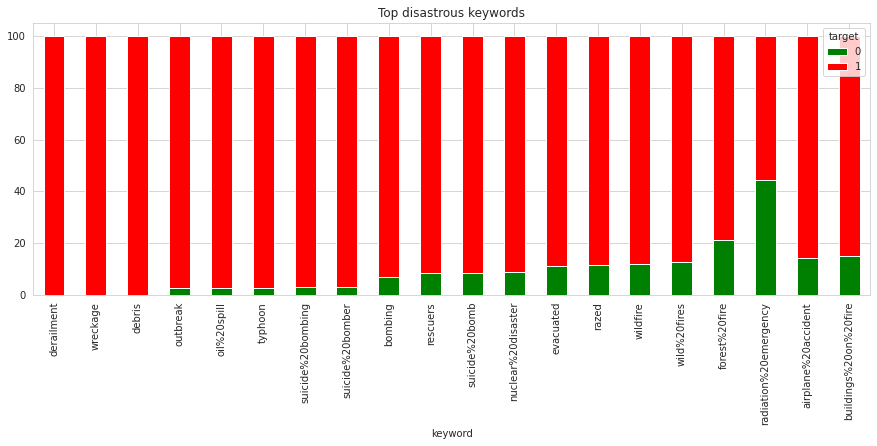

In [ ]:
# top 20 disastrous 
# and their distribution in dis and non_dis tweets 

counting_tweets.head(20).plot(kind="bar", stacked=True,
                              figsize = (15,5),
                              color = ['green', 'red']);
plt.title('Top disastrous keywords');

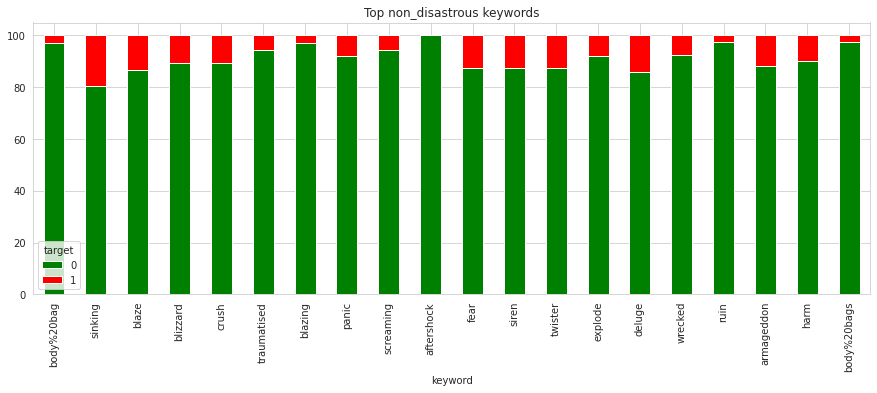

In [ ]:
# top 20 non_disastrous
counting_tweets.tail(20).plot(kind="bar", stacked=True,
                              figsize = (15,5),
                              color = ['green', 'red']);
plt.title('Top non_disastrous keywords');

Null Values and unuseful data:

Before building our model, we have to check whether each column contains enough information that can actually help us with the prediction.

Firstly we concatinate the training and testing set for an overall feature analysis and cleaning.

we'll delete the ids. Because their all unique for each tweet and there is no pattern among them.

Also we'll see how many null values each column has.

In [ ]:
df_concat = pd.concat([df_train, df_test], axis = 0) # concatinating along the 0 axis(rows).
for df in [df_train, df_test, df_concat]:
    df.drop(columns = ['id'], inplace = True) # dropping id and inplacing it


print('null values of each field:\n', df_concat.isnull().sum())

null values of each field:
 keyword       87
location    3638
text           0
target      3263
dtype: int64


As we can see more than 30 precent of the location and about 8 precent of keyword is null. Let's fill the null values with no_keyword and no_location for better undrestanding and viz.

In [ ]:
for df in [df_train, df_test, df_concat]:

    df.keyword.fillna('no_keyword', inplace = True)
    df.location.fillna('no_location', inplace = True)

Checking the distribution and generating new features

One important thing we have to check is whether or not our test and training set are from the same dataset. It's important because we have to know if there is enough similarity between them that we can rely on our training set to predict the testing set. Sometimes when they're not so similar, a more biased prediction can give us better scores. One way to check this is to check the distribution of the data, like here we can check the distribution of keywords and whether or not both training and testing set have the same keywords.

In [ ]:
assert df_train.keyword.all() == df_test.keyword.all()

# this statement asserts each serie and doesn't give an error when the two parts are equal.
# here we didn't get any error so we can assume that they are indeed from one source.

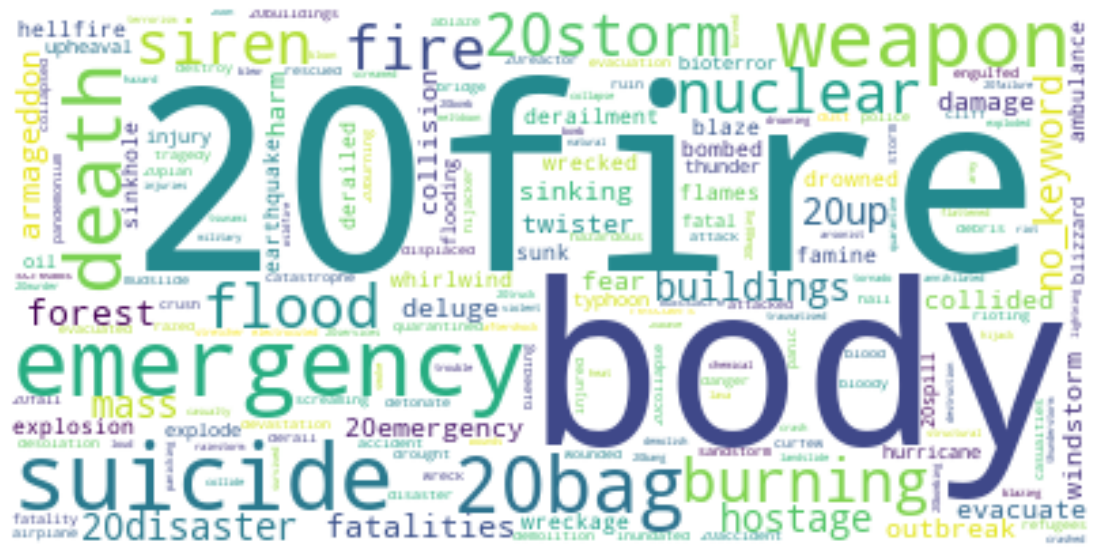

In [ ]:
#tweet_mask = np.array(Image.open("../input/twitterlogo3/twitter-logo-png-transparent.png"))
wc = WordCloud(collocations=False,
               background_color="white",
               max_words=200,
               #mask = tweet_mask,
               contour_color='steelblue',
               contour_width=10,)

# Generate a wordcloud
wc.generate(" ".join(df_train['keyword']))


# show
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

After checking the keywords, we want to check the distribution of the datasets fields and it's features. We'll get to know our dataset by generating new features.



In [ ]:
# for preprocessing

from wordcloud import STOPWORDS
import regex as re
import string
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
!pip install sentencepiece
import sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 32.2 MB/s 


In [ ]:
# count of words in every text

df_concat['word_count'] = \
df_concat['text'].apply(lambda x : len(str(x).split()))

# count of stopwords
# stopwords : words like 'is', 'he', 'a', 'she'

df_concat['stop_words'] =\
df_concat['text'].apply(lambda x : len([w for w in str(x).lower().split() \
                                    if w in STOPWORDS]))

# how many urls were in the text

df_concat['url_count'] =\
df_concat['text'].apply(lambda x : len([w for w in str(x).lower().split() \
                                    if 'http' in w or 'https' in w]))


# the mean of the words in each tweet

df_concat['mean_word_length'] =\
df_concat['text'].apply(lambda x :\
                        np.mean([len(w) for w in str(x).split()]))

# how many characters like '!', '#', '.', '\' were in text

df_concat['punc_count'] = \
df_concat['text'].apply(lambda x :\
                        len([w for w in str(x) \
                        if w in string.punctuation]))

# how many hashtags?

df_concat['hashtag_count'] = \
df_concat['text'].apply(lambda x :\
                        len([w for w in str(x) \
                        if w == '#']))

# how many mentions with '@'

df_concat['mention_count'] = \
df_concat['text'].apply(lambda x :\
                        len([w for w in str(x) \
                        if w == '@']))

# now we separate the concatinated dataset
# to observe each dataset's behaviour

train1 = df_concat.iloc[ : df_train.shape[0], :]
test1 = df_concat.iloc[df_train.shape[0] :, :]

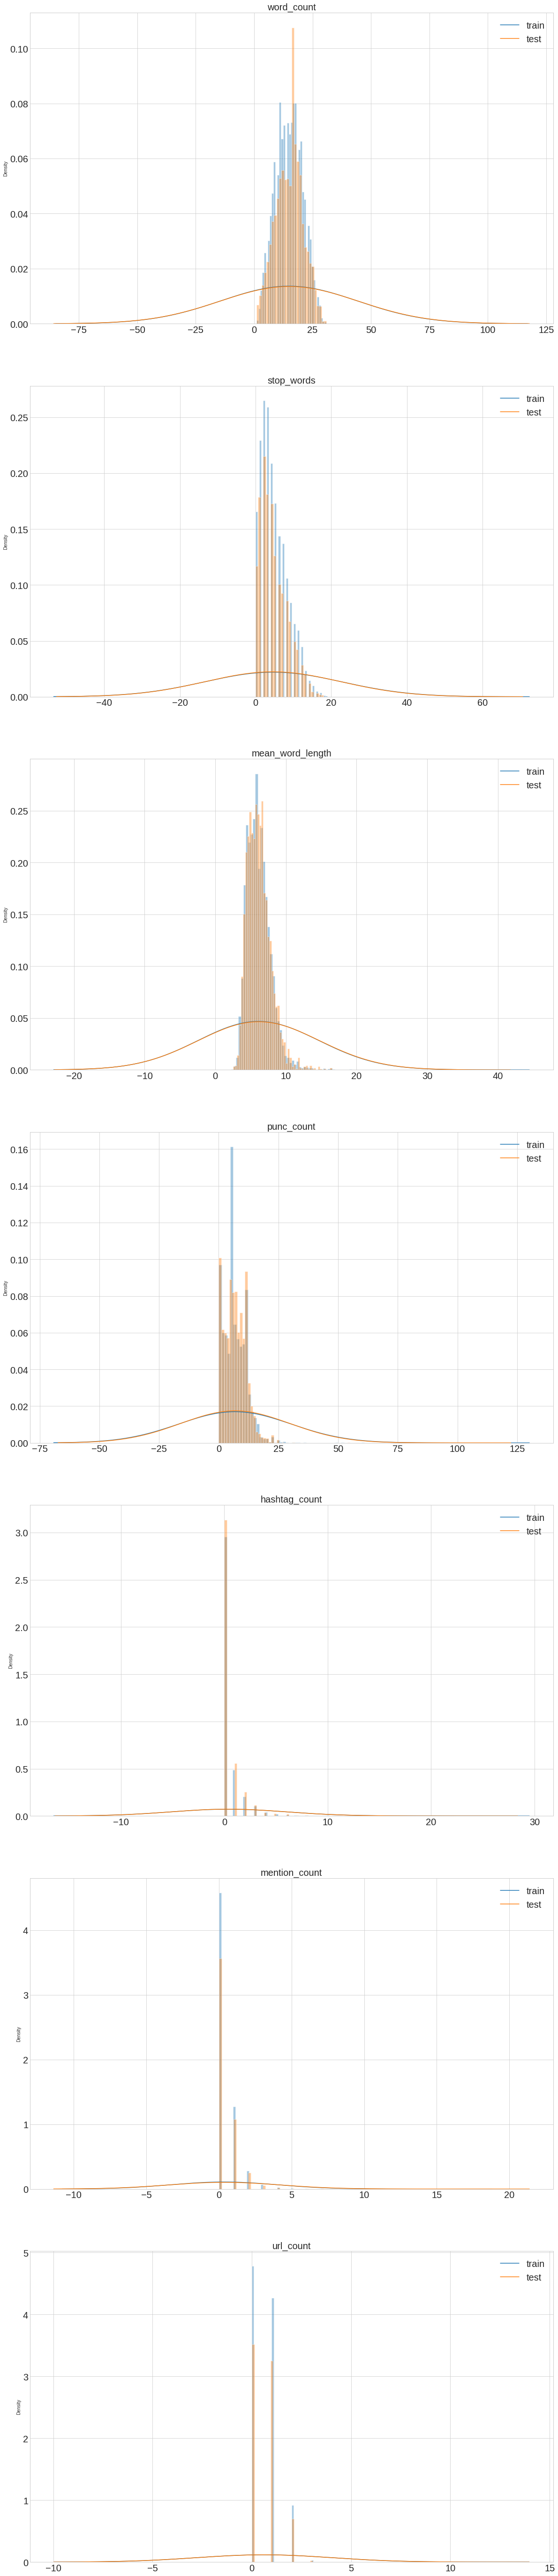

In [ ]:
fields = ['word_count', 'stop_words', 
         'mean_word_length', 'punc_count','hashtag_count', 
         'mention_count', 'url_count',]



plt.style.use('seaborn-whitegrid')

f, axes = plt.subplots(len(fields), 1,
                       figsize = (20, 100))


for i, field in enumerate(fields):

    s = sns.distplot(train1.loc[:, field], 
                 ax = axes[i], kde_kws={'bw':5})
    
    sns.distplot(test1.loc[:, field], 
                 ax = axes[i], kde_kws={'bw':5})
    
    axes[i].set_title(field, fontsize = 20)
    
    axes[i].tick_params(labelsize = 20);
    
    axes[i].set_xlabel('', fontsize = 20);
    
    s.legend(labels = ['train', 'test'], fontsize = 20)

As we saw here the distribution of training and testing set are very alike and we can assume that indeed these two are from one dataset.

Now we'll see how these features differ in disastrous and non_disastrous tweets.

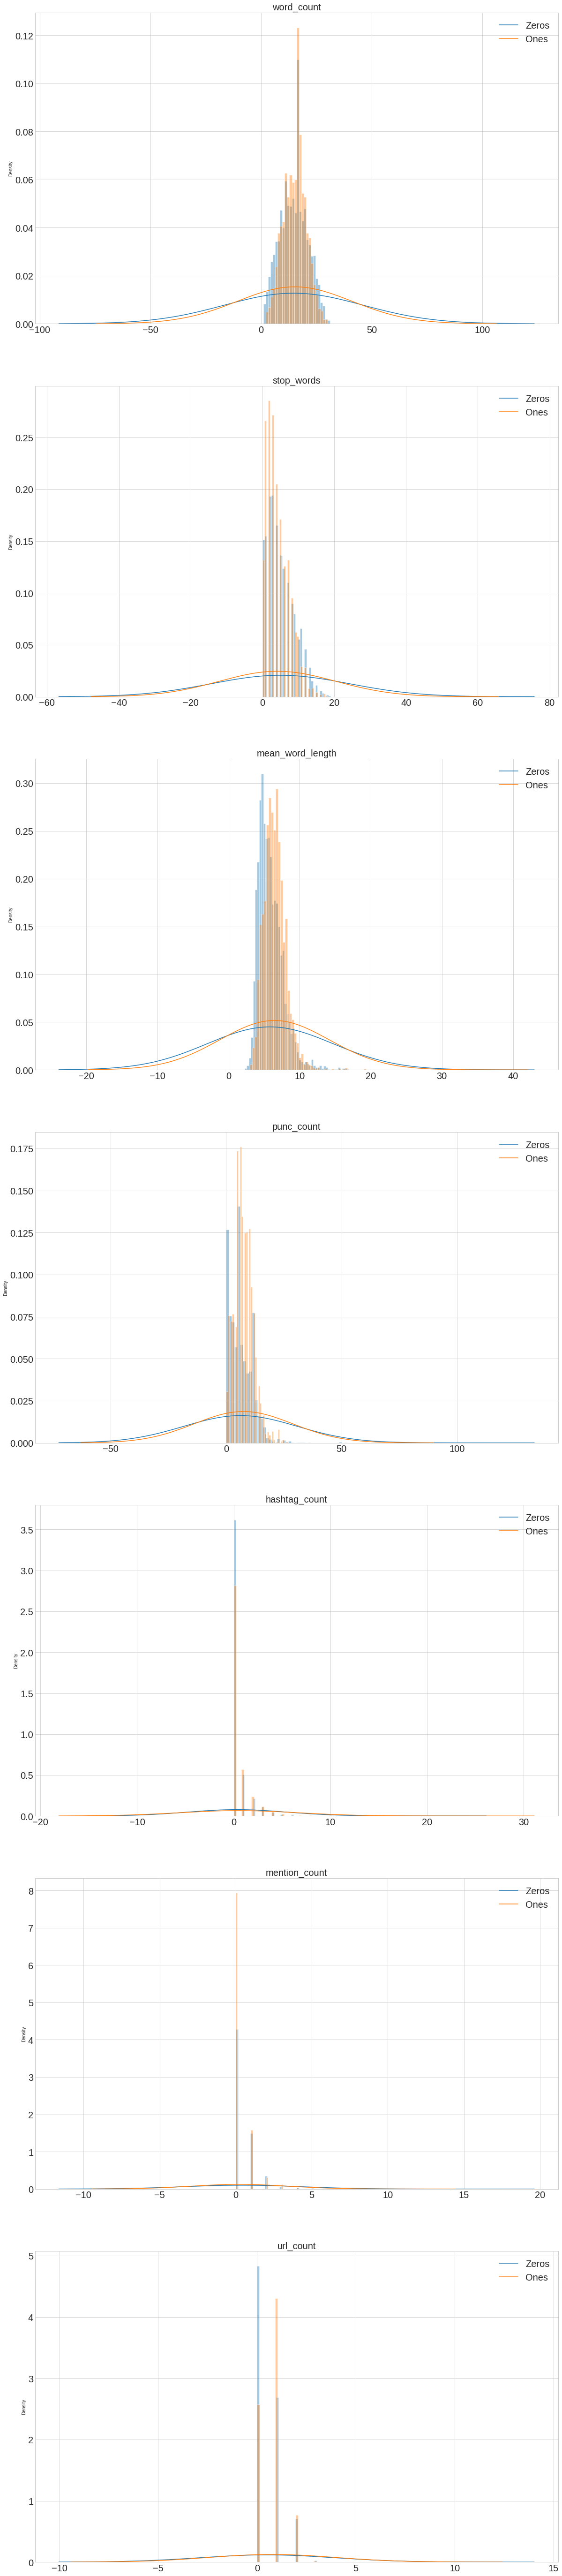

In [ ]:
plt.style.use('seaborn-whitegrid')

f, axes = plt.subplots(len(fields), 1,
                       
                       figsize = (20, 100))

train1_1 = train1[train1.target != 0]
train1_0 = train1[train1.target != 1]


for i, field in enumerate(fields):
    


    sns.distplot(train1_0.loc[:, field], ax = axes[i],
                label = 'zeros', kde_kws={'bw':5})
    
    
    s = sns.distplot(train1_1.loc[:, field], ax = axes[i],
                    label = 'ones', kde_kws={'bw':5})
    
    
    axes[i].set_title(field, fontsize = 20)
    
    axes[i].tick_params(labelsize = 20);
    
    axes[i].set_xlabel('');

    
    s.legend(labels = ['Zeros', 'Ones'], fontsize = 20)

Conclusion from data generation:
Disastrous tweets(which are usually formal and from news), have a less varied length, stop word count, and mean word length due to the more bell shaped the curve of them are. They are also a little longer than non_disastrous tweets which are casual and written by people. other features like hashtag,mention and url count are very much the same and can't help us much in our prediction.

visualizing the target Distribution
The next thing we have to check and be careful about is the distribution of target.

If we have more ones than zeros, then we should use Stratified Cross Validation for our training process. Here we can use pie chart because our distribution isn't that much

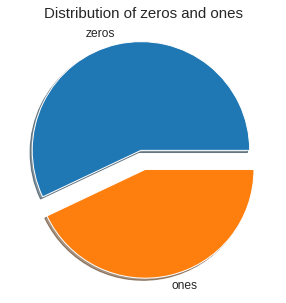

In [ ]:
fig, ax_ = plt.subplots(figsize = (20,5))

explode = (0.09, 0.09)

ax_.pie(x = df_train.groupby(['target']).count()['text'],
        labels = ['zeros', 'ones'], shadow = True,  
        pctdistance = '%10f%%', explode= explode,
        startangle = 0, textprops={'size': 'larger'});

ax_. set_title('Distribution of zeros and ones', fontsize = 15);

we see that they are somehow equally distributed, but we're safer with a stratified kfold to sure we have the same proportion in every fold.

This is were we dive into the actuall text and see how clean or dirty it is. Lets first see what words(unigrams) the text contains:

In [ ]:
def make_ngrams(text, n):
    
    c_vectorizer = CountVectorizer(ngram_range = (n,n)).fit(text)
    
    vocab = c_vectorizer.transform(text)

    count_of_each_ngram = vocab.sum(axis = 0)
    
    word_and_count = [(word, count_of_each_ngram[0, i]) for word, i in c_vectorizer.vocabulary_.items()]
    
    # sorting
    word_and_count = {k:v for k,v in sorted(word_and_count, key = lambda x: x[1], reverse=True) }
    
    return word_and_count

In [ ]:
make_ngrams(df_concat.text, 1)

{'co': 6807,
 'http': 6161,
 'the': 4616,
 'to': 2837,
 'in': 2808,
 'of': 2610,
 'and': 2023,
 'is': 1392,
 'you': 1284,
 'for': 1244,
 'on': 1237,
 'it': 1141,
 'my': 976,
 'that': 852,
 'with': 797,
 'by': 777,
 'at': 748,
 'this': 704,
 'https': 618,
 'from': 614,
 'are': 600,
 'be': 596,
 'was': 553,
 'û_': 514,
 'have': 513,
 'amp': 510,
 'like': 493,
 'as': 485,
 'up': 471,
 'just': 459,
 'me': 445,
 'we': 442,
 'but': 436,
 'so': 432,
 'not': 431,
 'your': 429,
 'out': 412,
 'no': 401,
 'all': 380,
 'will': 372,
 'after': 369,
 'fire': 367,
 'can': 362,
 'an': 358,
 'if': 352,
 'he': 351,
 'when': 347,
 'has': 341,
 'get': 336,
 'new': 329,
 'they': 327,
 'more': 325,
 'via': 325,
 'about': 312,
 'what': 311,
 'now': 309,
 'or': 294,
 'how': 293,
 'news': 288,
 'people': 285,
 'one': 283,
 'who': 271,
 'there': 266,
 'over': 257,
 'don': 251,
 'been': 249,
 'do': 246,
 'into': 239,
 're': 233,
 'emergency': 229,
 'video': 228,
 'disaster': 220,
 'would': 214,
 'police': 199,
 '

From what we see here, there are lots of repetetive words that are getting in our way to get to important, words that define the content of tweets. We'd better clean our text and then check on uni/bio/trigrams.

Text Cleaning

In natural language processing, one of the best method for text classification is using pretrained text. I'll explain embeddings in another kenel but for now the most important thing to know is that here with GloVe we can have a dictionary of words, a dictionary that leads us to know which words are spelled correctly and can be identified by a neural netword.



In [ ]:
import pickle
glove_dict_vector = np.load('/content/gdrive/MyDrive/DATA255_Group_Work/data/glove.840B.300d.pkl', allow_pickle = True)

Right now, our glove_dict_vector is a dictionary with the keys being the words and the values being the embedding vectors. These vectors will help us in setting the initial weights for our neural netword and getting to the answers sooner.

Ok, but first lets utilize our text by seeing how many words are recognized by the GloVe dictionary.

In [ ]:
def cov_check(texts, pretrained_vocab):
    
    oov_dict = {}
    oov_num = 0
    cov_num = 0

    
    for text in texts:
        for word in text.split():

            vector = pretrained_vocab.get(word)

            if vector is not None:
                cov_num += 1

            elif word in oov_dict.keys():
                oov_dict[word] += 1
                oov_num += 1

            else: 
                oov_dict[word] = 1
                oov_num += 1

    oov_dict = {k:v for k, v in sorted(oov_dict.items(),
                                       key = lambda x:x[1],
                                       reverse = True)}
    
    print('Number of covered words: {}, \nNumber of uncovered wrods: {}'.format(cov_num, oov_num))
    print('Coverage precentage: {:.2f}'.format(cov_num /(cov_num + oov_num) *100))

    return oov_dict

In [ ]:
oov = cov_check(df_concat.text, glove_dict_vector)

print('Most used, unrecognized words:\n', list(oov)[:10])

Number of covered words: 133778, 
Number of uncovered wrods: 28515
Coverage precentage: 82.43
Most used, unrecognized words:
 ['\x89Û_', '\x89ÛÒ', 'MH370:', 'Latest:', '\x89ÛÓ', '#prebreak', "Legionnaires'", 'w/', "he's", 're\x89Û_']


In [ ]:
def clean(tweet):
    
    o = ''
    rep_redicilous_words = {
            "China\x89Ûªs":"china's", "let\x89Ûªs": "let's",
            "\x89ÛÏWhen":'when',"fromåÊwounds":'from wounds',
           "åÊ":o , "åÈ":o, "JapÌ_n":"Japan", 
           "Ì©":o, "å¨":o, "SuruÌ¤":"Suruc",
          "åÇ":o, "å£3million":" a million",
           "åÀ":o, "he's":"he is", "there's":"there is",
          "We're":"We are", "That's":"That is",
           "won't":"will not", "They're":"They are",
           "Can't":"Can not",
          "wasn't":"was not", "don\x89Ûªt":"do not",
           "aren't":"are not", "isn't":"is not",
          "What's":"What is", "haven't":"have not",
           "hasn't":"has not", "There's":"There is",
          "He's":"He is", "It's":"It is",
           "You're":"You are", "I'M":"I am", 
           "shouldn't":"should not",
          "wouldn't":"would not", "i'm":"I am", "Isn't":"is not",
          "Here's":"Here is", "you've":"you have",
           "you\x89Ûªve": "you have", "we're":"we are",
           "What's":"What is", "couln't":"could not",
           "we've": "we have", "it\x89Ûªs": "it is",
           "doesn\x89Ûªt": "does not", "It\x89Ûªs": "It is",
           "Here\x89Ûªs":"Here is", "Who's": "who is",
           "I\x89Ûªve": "I have", "y'all":"you all",
           "can\x89Ûªt": "cannot", "would've": "would have",
           "it'll":"it will", "we'll": "we will",
           "wouldn\x89Ûªt": "would not", "We've": "We have",
           "he'll": "he will", "Didn't": "Did not",
           "they'll": "they will", "they'd": "they would",
           "DON'T": "DO NOT", "That\x89Ûªs": "That is",
           "they've": "they have", "i'd": "I would",
           "should've": "should have", "You\x89Ûªre": "You are",
           "where's": "where is", "Don\x89Ûªt": "Do not",
           "we'd": "we would","i'll": "I will",
           "weren't": "were not", "They're": "They are",
           "Can\x89Ûªt": "Cannot", "you\x89Ûªll": "you will", 
           "I\x89Ûªd": "I would", "let's": "let us",
           "it's": "it is", "can't": "cannot", 
           "don't": "do not", "i've": "I have", 
           "that's": "that is", "i'll": "I will", 
           "doesn't": "does not", "i'd": "I would",
           "didn't": "did not", "ain't": "am not", 
           "you'll":"you will", "I've": "I have", 
           "Don't": "do not", "I'll": "I will",
           "I'd": "I would", "you'd": "You would",
           "Ain't": "am not", "donå«t": "do not",
           "ÏWhen":"When","ÏHatchet":"Hatchet",
            "CollisionNo":"Collision No"
        }
    
    
    
    # these have to be separatedly cleaned  
    # because of their format
    tweet = re.sub(r"\x89û", "", tweet)
    tweet = re.sub(r"\x89Û", "", tweet)
    tweet = re.sub(r"\x89ã¢", "", tweet)
    tweet = re.sub(r"\x89Ûª", "", tweet)
    tweet = re.sub(r"\x89Û÷", "", tweet)
    tweet = re.sub(r"ª", "", tweet)
    tweet = re.sub(r"÷", "", tweet)
    tweet = re.sub(r"\x9d", "", tweet)
    tweet = re.sub(r"\x89ûò", "", tweet)
    
    
    
    # character_entity_refrences
        
    rep_character_entity_refrences = {"&gt;": ">", "&lt;":"<",
                                      "&amp;": "&"}
    
    # SLANG!
    
    slang_and_abbr = {'goooooooaaaaaal':'goal', 'Rockyfire':'rocky fire',
            'sleepjunkies':  'sleep junkies',
            'floydmayweather' :'floyd mayweather','Beyhive':'Beyoncé fans',
            "TrapMusic": "Trap Music", "djicemoon": "dj icemoon",
            'HuffPostRelig':"HuffPost Religion",
            "MH370":"Malaysia Airlines Flight 370" ,"prebreak":"pre-break",
            'TyphoonDevastated':'Typhoon Devastated',
            'ChicagoArea':'Chicago Area',
            'localarsonist':'local arsonist',"USAgov": "USA government",
            "TAXIWAYS":"taxi ways","Collision1141":"Collision",
            'ÏThe':'The',"savebees":"save bees", "GreenHarvard": "Green Harvard",
            'OPPRESSIONS':'Oppression', 'ÏRichmond':'Richmond',
            'mÌ¼sica':'music','53inch':'53 inch','Politifiact':'PolitiFact',
            'saddlebrooke':'Saddlebrooke', 
            '11YearOld':'11yearold',"MNPDNashville": "Metropolitan Nashville Police Department",
            'TfLBusAlerts': 'TfL Bus Alerts', 'HatCap':'Hat Cap',
            "GMMBC": "Greater Mt Moriah Baptist Church",'versethe':'verse the',
            'KOIN6News':'KOIN 6 News', "LiveOnK2":'Live On K2',
            'NestleIndia': 'Nestle India', 'humanconsumption': 'human consumption',
            'socialnews':'social news', 'FaroeIslands':'Faroe Islands',
            'ArianaGrande':'Ariana Grande', 'animalrescue':'animal rescue',
            '4PlayThursdays':'Foreplay Thursdays', 'RoyalCarribean':'Royal Carribean',
            'foodscare':'food scare', 'NoSurrender':'No Surrender',
            'anyname':'any name', 'MicheleBachman':'Michele Bachman',
            'iTunesMusic':'iTunes Music', 'camilacabello97':'Camila Cabello',
            'thankU':'thank you', 'GodsLove': "God's Love",
             "usNWSgov": "United States National Weather Service",        
            'ibooklove':'I book love','lavenderpoetrycafe':'lavender poetry cafe' ,      
            'narendramodi':'Narendra Modi', '15PM':'15 PM',
            '38PM':'38 PM',"rightwaystan": "Richard Tan",
            'Soudelor':'Typhoon', 'Time2015':'Time 2015',
            'IranDeal':'Iran Deal', 'PantherAttack':'Panther Attack',
            'MikeParrActor':'Mike Parr Actor', 'NASAHurricane':'NASA Hurricane',
            'ProphetMuhammad':'Prophet Muhammad', 'StrategicPatience':'Strategic Patience', 
            'ViralSpell':'Viral Spell', "Suruc": "Sanliurfa",
             "okwx": "Oklahoma City Weather","IDFire": "Idaho Fire",         
            "DETECTADO": "Detected", 'KerrickTrial':'Kerrick Trial',
             'offers2go':'offers to go', 'RockyFire':'Rocky Fire',
            'NickCannon':'Nick Cannon','aRmageddon':'Armageddon',
             'Friend59':'Friend 59','ÏThats':'That is',
            'PokemonCards':'Pokemon Cards','Captainn':'Captain'   ,   
             'thatswhatfriendsarefor':'that is what friends are for',
            "RockBottomRadFM": "Rock Bottom Radio",'ÏYou':'You',
            'nikeplus':'nike plus', "PAKPATTAN": "Pakpattan",
            "samanthaturne19":"Samantha Turner",
            "DebateQuestionsWeWantToHear":"debate questions we want to hear",
             "JonVoyage": "Jon Stewart","TeamHendrick":"Hendrick Motorsports",
            'BakeOffFriends': 'Bake-off Friends', 'KerrickTrial':'Kerrick Trial',
            "DETECTADO": "Detected","Suruc": "Sanliurfa",'MTVHottest':'MTV Hottest',
            'AbbsWinston':'Abbs Winston', 'bookboost':'book boost', 
            'realmandyrain':'Mandy Rain', 'OffensiveContent':'Offensive Content',
            'NickCannon':'Nick Cannon', 'onlinecommunities':'online communities',
            'DavidVonderhaar':'David Vonderhaar', 'WorstSummerJob':'Worst Summer Job',
            'jimmyfallon':'jimmy fallon', 'ArtistsUnited':'Artists United', 
            'HarryBeCareful':'Harry Be Careful', 'weathernetwork':'weather network',
            'NewsInTweets':'News In Tweets', 'RickPerry':'Rick Perry',
            'NASASolarSystem':'NASA Solar System', 'stormchase':'stormchaser',
            'TRAUMATISED':'Traumatised', 'OutBid':'Outbid', 'LivingSafely':'Living Safely',
            'OriginalFunko':'Original Funko', 'ÏStretcher':'Stretcher',
            'UndergroundRailraod':'Underground Railraod',"gunsense": "gun sense",
            'LondonFire':'London Fire', 'AllLivesMatter':'All Lives Matter', 
            'wordpressdotcom':'wordpress', 'BlackLivesMatter':'Black Lives Matter', 
            'FantasticFour':'Fantastic Four', '16yr': '16 year',
            "SummerFate": "Summer Fate", 'yazidis':'yazid',
            "realDonaldTrump" : "real Donald Trump", "StandwithPP":"Stand with Planned Parenthood",     
            "ModiMinistry" : "Modi Ministry", "GraysonDolan":"Grayson Dolan",
            "weallheartonedirection" : "we all heart one direction", 
            "rapidcity":"rapid city", "afterShock":"after Shock",
            "aftershock":"after Shock", "VideoVeranoMTV":"Video Verano MTV", "ScottWalker": "Scott Walker",
            "scoopit":"scoop it", "hermancranston":"herman cranston",
            "PeterDutton":"Peter Dutton", "Hiroshima70": "Hiroshima",
            "LiteraryCakes" : "Literary Cakes", "PlannedParenthood": "Planned Parenthood",
            "AskConnor" : "Ask Connor", "OffensiveContent":"Offensive Content",
            "CindyNoonan":"Cindy Noonan", "Rightways":"Right ways", 
            "TornadoGiveaway" : "Giveaway", "MTVSummerStar":"MTV Summer Star",
            "FreeBitcoin":"Free Bitcoin", "ColoradoAvalanche":"Colorado Avalanche",
            "FoxNew":"Fox New", "letsFootball": "let us Football","cnewslive":"C News Live",
            "thisiswhywecanthavenicethings":"this is why we can not have nice things",
            "IvanBerroa":"Ivan Berroa", "c4news":"c4 News", "YoNews":"News",
            "johngreen":"John Green", "WindStorm":"Wind Storm", 
            "BioTerrorism" : "Bio-terrorism", "bioterrorism":"bio-terrorism",
            "s2g":"swear to God", "taylorswift13":"Taylor Swift",
            "MissionHills":"Mission Hills", "cityofcalgary": "City of Calgary",
            "CityofCalgary": "City of Calgary", "9NewsGoldCoast":"9 News Gold Coast",
            "jamaicaplain": "Jamaica Plain", "liveleakfun": "live leak fun",
            "michaelgbaron":"Michael Baron", "HillaryClinton":"Hillary Clinton",
             "edsheeran": "Ed Sheeran", "Throwingknifes": "throwing knifes", 
            "IndianNews":"Indian News", "peterjukes": "Peter Jukes", 
            "LuchaUnderground": "Lucha Underground", 
            "greatbritishbakeoff": "great british bake off",
            "CommoditiesAre": "Commodities are", "tubestrike": "tube strike",
            "Daesh":"ISIS","cnnbrk": "CNN Breaking News",      
             "RondaRousey": "Ronda Rousey","ÏWe" :"We",
            "GOPDebate": "GOP Debate", "yycstorm": "Calgary Storm",
            "SouthDowns": "South Downs", "Ph0tos":"Photos", 
            "exp0sed":"exposed", "auspol": "Australian politics",
            "megynkelly": "Megyn Kelly", "GRupdates":"GR updates",
            "THISIZBWRIGHT": "Bonnie Wright", "02PM": "02 PM",
            "listenlive":"listen live", "CDCgov":"CDC gov",
            "HarvardU":"Harvard", "JohnEJefferson":"John Jefferson",
            "TweetLikeItsSeptember11th2001": "Tweet like it is september 11th 2001",        
            "buildingsÓwe":"buildings we","AskCharley": "Ask Charley" ,
            "ScreamQueens": "Scream Queens", "BillNeelyNBC":"Bill Neely NBC",
            "mishacollins": "Misha Collins", "BeClearOnCancer": "Be Clear On Cancer",
            "bancodeseries": "banco de series", "SOUDELOR": "Typhoon ",
            "KurtSchlichter":"Kurt Schlichter","ProtectDenaliWolves":"Protect Denali Wolves",
                     }
    
    

    # adding all toghether and substituding

    for k,v in {**slang_and_abbr, **rep_redicilous_words,
                **rep_character_entity_refrences,}.items():

        tweet = re.sub(k, v, tweet)
        
        
    # HTTP
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet)

        
    # PUNCTUATION
    
    tweet = tweet.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))

        
    return tweet

In [ ]:
df_concat['cleaned_text'] = df_concat.text.apply(lambda x : clean(x))

oov = cov_check(df_concat['cleaned_text'], glove_dict_vector)

Number of covered words: 153370, 
Number of uncovered wrods: 5630
Coverage precentage: 96.46


In [ ]:
# Cleaning the Mislabeled
train = df_concat[:df_train.shape[0]]
test = df_concat[df_train.shape[0]:]

In [ ]:
train.groupby('text').nunique().sort_values(by = 'target', ascending = False)[['target']].head(5)

,target
text,
like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit,2
Hellfire! We donÛªt even want to think about it or mention it so letÛªs not do anything that leads to it #islam!,2
The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.',2
In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!,2
To fight bioterrorism sir.,2


In [ ]:
df_mislabeled = train.groupby(['text']).nunique().sort_values(by = 'target', ascending = False)

df_mislabeled = df_mislabeled[df_mislabeled.target > 1]['target'].index.tolist()

In [ ]:
for tweet in df_mislabeled:
    print(train[train.text == tweet][['text','target']])

                                                   text  target
1221  like for the music video I want some real acti...     1.0
1349  like for the music video I want some real acti...     0.0
                                                   text  target
4306  Hellfire! We donÛªt even want to think about ...     0.0
4320  Hellfire! We donÛªt even want to think about ...     1.0
                                                   text  target
4284  The Prophet (peace be upon him) said 'Save you...     0.0
4286  The Prophet (peace be upon him) said 'Save you...     0.0
4292  The Prophet (peace be upon him) said 'Save you...     1.0
4304  The Prophet (peace be upon him) said 'Save you...     0.0
4309  The Prophet (peace be upon him) said 'Save you...     0.0
4318  The Prophet (peace be upon him) said 'Save you...     1.0
                                                   text  target
6614  In #islam saving a person is equal in reward t...     0.0
6616  In #islam saving a person is equal

In [ ]:
train['relabeled'] = train.target
# you can change it by their text or index in our dataframe
train.loc[train.text == df_mislabeled[0], 'relabeled'] = 0
train.loc[train.text == df_mislabeled[1], 'relabeled'] = 0
train.loc[train.text == df_mislabeled[2], 'relabeled'] = 0
train.loc[train.text == df_mislabeled[3], 'relabeled'] = 0
train.loc[train.text == df_mislabeled[4], 'relabeled'] = 0
train.loc[train.text == df_mislabeled[5], 'relabeled'] = 0
train.loc[train.text == df_mislabeled[6], 'relabeled'] = 0
train.loc[train.text == df_mislabeled[7], 'relabeled'] = 0
train.loc[train.text == df_mislabeled[8], 'relabeled'] = 0
train.loc[train.text == df_mislabeled[9], 'relabeled'] = 1
train.loc[train.text == df_mislabeled[10], 'relabeled'] = 0
train.loc[train.text == df_mislabeled[11], 'relabeled'] = 1
train.loc[train.text == df_mislabeled[12], 'relabeled'] = 0
train.loc[train.text == df_mislabeled[13], 'relabeled'] = 0
train.loc[train.text == df_mislabeled[14], 'relabeled'] = 1
train.loc[train.text == df_mislabeled[15], 'relabeled'] = 1
train.loc[train.text == df_mislabeled[16], 'relabeled'] = 0
train.loc[train.text == df_mislabeled[17], 'relabeled'] = 0

In [ ]:
# check if they are all correctly labeled:
for tweet in df_mislabeled:
    print(train[train.text == tweet][['text','relabeled']])

                                                   text  relabeled
1221  like for the music video I want some real acti...        0.0
1349  like for the music video I want some real acti...        0.0
                                                   text  relabeled
4306  Hellfire! We donÛªt even want to think about ...        0.0
4320  Hellfire! We donÛªt even want to think about ...        0.0
                                                   text  relabeled
4284  The Prophet (peace be upon him) said 'Save you...        0.0
4286  The Prophet (peace be upon him) said 'Save you...        0.0
4292  The Prophet (peace be upon him) said 'Save you...        0.0
4304  The Prophet (peace be upon him) said 'Save you...        0.0
4309  The Prophet (peace be upon him) said 'Save you...        0.0
4318  The Prophet (peace be upon him) said 'Save you...        0.0
                                                   text  relabeled
6614  In #islam saving a person is equal in reward t...       

In [ ]:
# specifying the maximum length of each tweet
maximum = 0
for tweet in df_concat.cleaned_text:
    x = len(tweet.split())
    if x > maximum:
        maximum = x
        
print(maximum)

34


In [ ]:
from keras_preprocessing.sequence import pad_sequences
from tensorflow import keras
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.initializers import Constant

# For checking and evaluating our models

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

In [ ]:
# creating a vocab of my data
vocab_of_text = set(" ".join(df_concat.text).lower().split())


# creating a dictionary of vocab with index starting with 1
# because index 0 will be for our padding
vocab_of_text = dict(enumerate(vocab_of_text, 1))


# putting the words first and then indices
indexed_vocab_of_text = {k:v for v,k in dict(vocab_of_text).items()}



def text_to_sequence_my_vocab(text, word_index):
    tokens = text.lower().split()
    return [word_index.get(token) for token in tokens if word_index.get(token) is not None]


# giving ids

df_concat['sequences'] = df_concat.text\
.apply(lambda x : text_to_sequence_my_vocab(x, indexed_vocab_of_text))

max_len_seq = 34

# padding

padded = pad_sequences(df_concat['sequences'] ,
              maxlen = max_len_seq, padding = 'post', 
              truncating = 'post')


padded.shape # this is (len(train)+len(test) ,max_len_seq)

padded_train = padded[:train.shape[0]]
padded_test = padded[train.shape[0]:]

In [ ]:
# creating a matrix for initial weights
dim = 300
vocab_matrix = np.zeros((len(indexed_vocab_of_text)+1, dim))



# searching for vactor of each word in Glove
for word, i in indexed_vocab_of_text.items():
    

    # embedding index is a dictionary of Glove
    # with the shape of 'word': vecor
    vector = glove_dict_vector.get(word)
    
    if vector is not None:
        vocab_matrix[i] = vector

# check that the matrix of weights is not empty
# and there's no bug in your code with
# np.all(vocab_matrix == 0)

In [ ]:
model = keras.models.Sequential()

embedding = keras.layers.Embedding(input_dim=len(indexed_vocab_of_text)+1, 
                                   output_dim= dim , mask_zero = True,
                                   embeddings_initializer=Constant(vocab_matrix),
                                   trainable = True,
                                   input_length = max_len_seq)
model.add(embedding)
model.add(keras.layers.AveragePooling1D())
model.add(keras.layers.LSTM(50, dropout=0.2, recurrent_dropout = 0.2))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()


#optimizer = SGD(learning_rate = 0.1, momentum = 0.4 )

model.compile(optimizer = 'Adam',
              loss = keras.losses.BinaryCrossentropy(from_logits=True),
              metrics = 'accuracy')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 34, 300)           10984200  
                                                                 
 average_pooling1d (AverageP  (None, 17, 300)          0         
 ooling1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 50)                70200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 11,054,451
Trainable params: 11,054,451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(padded_train, train.target, shuffle = True) 

model.fit(x = x_train, y = y_train, batch_size= 200, epochs = 3,
          validation_data = (x_test, y_test))

Epoch 1/3
29/29 [==============================] - 11s 105ms/step - loss: 0.6103 - accuracy: 0.6642 - val_loss: 0.5248 - val_accuracy: 0.7684
Epoch 2/3
29/29 [==============================] - 3s 92ms/step - loss: 0.4255 - accuracy: 0.8199 - val_loss: 0.4749 - val_accuracy: 0.7915
Epoch 3/3
29/29 [==============================] - 3s 113ms/step - loss: 0.3407 - accuracy: 0.8609 - val_loss: 0.4877 - val_accuracy: 0.7868


In [ ]:
# now you can submit your predictions

model.fit(x = padded_train, y = train.target,
          epochs = 3, batch_size = 200, verbose = 2)

y_pred = model.predict(padded_test)

Epoch 1/3
39/39 - 3s - loss: 0.3140 - accuracy: 0.8757 - 3s/epoch - 87ms/step
Epoch 2/3
39/39 - 3s - loss: 0.2272 - accuracy: 0.9163 - 3s/epoch - 84ms/step
Epoch 3/3
39/39 - 3s - loss: 0.1454 - accuracy: 0.9510 - 3s/epoch - 84ms/step
102/102 [==============================] - 1s 6ms/step


In [ ]:
submission = pd.DataFrame(columns = ['id', 'target'])
submission['id'] = submission['id'].astype('int')
submission['target'] = np.round(y_pred).flatten().astype('float64')

submission.to_csv('submission.csv', index=False)